This notebook used the extreme gradient boosting (XGBoost) method to predict ice bed height using 5 variables ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']. Here both the old data and new interpolated data are used for prediction.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import h5py
import xarray as xr 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [4]:
def rmspe_1(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100

In [5]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

## Old Data

In [7]:
df_train=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/train.csv')
df_test=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/test.csv')
df_pred=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/y_test.csv')
data_1201=pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/df_1201.csv')

In [ ]:
df_test

,surf_x,surf_y,surf_vx,surf_vy,surf_elv,surf_dhdt,surf_SMB,track_bed_test_x,track_bed_test_y
0,-220025.0,-1697525.0,-81.467440,0.913897,1862.4003,-0.003780,0.374366,-220038.295520,-1.697568e+06
1,-220025.0,-1697675.0,-81.488320,1.039868,1862.3989,-0.003897,0.374305,-220038.408158,-1.697642e+06
2,-220025.0,-1697825.0,-81.496080,1.172581,1862.3975,-0.004014,0.374243,-220038.646540,-1.697789e+06
3,-220025.0,-1697975.0,-81.490715,1.312036,1862.3961,-0.004131,0.374181,-220038.939782,-1.697936e+06
4,-220025.0,-1698125.0,-81.514725,1.292812,1862.3948,-0.004248,0.374117,-220039.334272,-1.698083e+06
...,...,...,...,...,...,...,...,...,...
235967,-241925.0,-1871675.0,-109.031784,30.579424,1556.2831,-0.412165,-0.018388,-241867.395118,-1.871682e+06
235968,-241925.0,-1871675.0,-109.031784,30.579424,1556.2831,-0.412165,-0.018388,-241879.313090,-1.871664e+06
235969,-241925.0,-1871675.0,-109.031784,30.579424,1556.2831,-0.412165,-0.018388,-241890.904137,-1.871645e+06
235970,-242075.0,-1871375.0,-111.202000,31.286001,1555.5704,-0.418871,-0.016968,-242055.253924,-1.871391e+06


In [ ]:
data_1201

,Unnamed: 0,surf_x,surf_y,surf_vx,surf_vy,surf_dhdt,surf_SMB,surf_elv
0,0,-278075.0,-1697525.0,-117.986570,8.049935,-0.362801,0.102309,1348.6687
1,1,-278075.0,-1697675.0,-118.086580,8.429934,-0.363170,0.100127,1347.2958
2,2,-278075.0,-1697825.0,-118.103740,8.865048,-0.363538,0.098367,1346.9690
3,3,-278075.0,-1697975.0,-118.038060,9.355281,-0.363907,0.096918,1346.1609
4,4,-278075.0,-1698125.0,-117.793236,9.596583,-0.364276,0.095606,1345.8989
...,...,...,...,...,...,...,...,...
1442396,1442396,-98075.0,-1876925.0,-16.739680,7.869811,0.005050,0.332106,2530.5593
1442397,1442397,-98075.0,-1877075.0,-16.679783,7.903055,0.004754,0.332474,2530.5574
1442398,1442398,-98075.0,-1877225.0,-16.616787,7.968928,0.004459,0.332817,2530.5554
1442399,1442399,-98075.0,-1877375.0,-16.527618,8.169706,0.004163,0.333154,2530.5535


In [8]:
df_test_only_reading=df_test.drop(['track_bed_test_x','track_bed_test_y','surf_x', 'surf_y'],axis=1)
df_train_only_reading=df_train.drop(['track_bed_x','track_bed_y','surf_x', 'surf_y'],axis=1)
test_data_1201=data_1201.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)
test_data_1201_ordered = test_data_1201[['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']]

In [9]:
df_test_only_reading.keys(), df_train_only_reading.keys(), test_data_1201_ordered.keys()

(Index(['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB'], dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB',
        'track_bed_target'],
       dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB'], dtype='object'))

In [10]:
x1_train=df_train_only_reading.iloc[:,:-1]
y1_train=df_train_only_reading.iloc[:,-1:]
X_test_given=df_test_only_reading.iloc[:,:]
Y_test_given=df_pred.iloc[:,:]

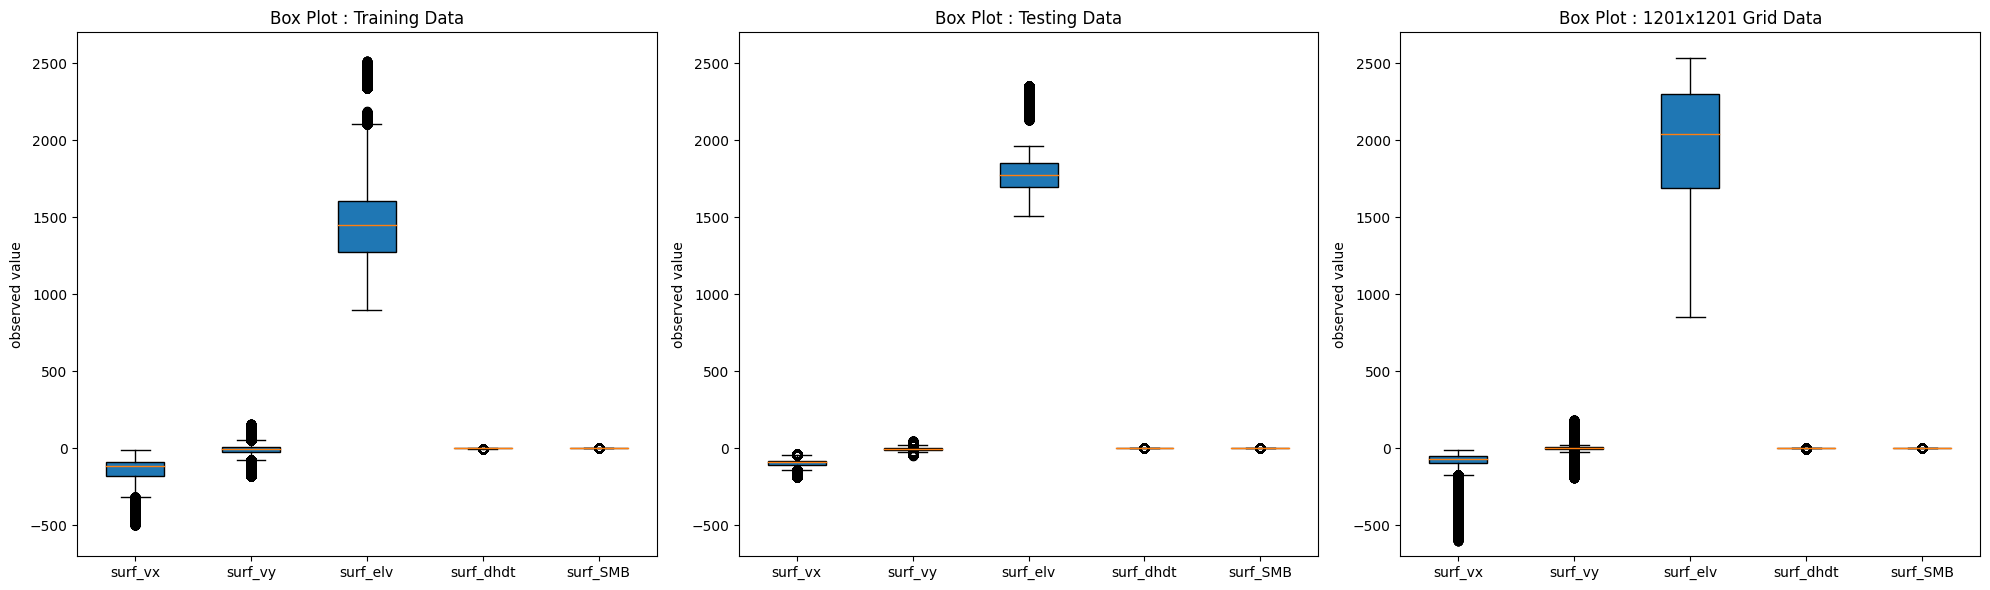

In [12]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-700, 2700])
plt.boxplot(x1_train, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-700, 2700])
plt.boxplot(X_test_given, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : Testing Data') 


plt.subplot(1, 3, 3)
plt.ylim([-700, 2700])
plt.boxplot(test_data_1201_ordered, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data') 

plt.tight_layout()
plt.show()

In [13]:
x1_train.shape, X_test_given.shape, test_data_1201_ordered.shape

((396734, 5), (235972, 5), (1442401, 5))

In [14]:
all_X = np.concatenate((x1_train, X_test_given, test_data_1201_ordered), axis=0)
all_X.shape

(2075107, 5)

In [15]:
y1_train.shape, Y_test_given.shape

((396734, 1), (235972, 1))

In [16]:
all_Y = np.concatenate((y1_train, Y_test_given), axis=0)
all_Y.shape

(632706, 1)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

all_X_nor = scaler_X.fit_transform(all_X)
all_Y_nor = scaler_Y.fit_transform(all_Y)

In [18]:
all_X_nor.shape, all_Y_nor.shape

((2075107, 5), (632706, 1))

In [19]:
#seperate the dependent and independent variable for train, test, and 1201 dataset
data_train_X = all_X_nor[0:396734, :]
data_train_Y = all_Y_nor[0:396734, :]
data_test_X = all_X_nor[396734:632706, :]
data_test_Y = all_Y_nor[396734:, :]
data_1201_X = all_X_nor[632706:, :]

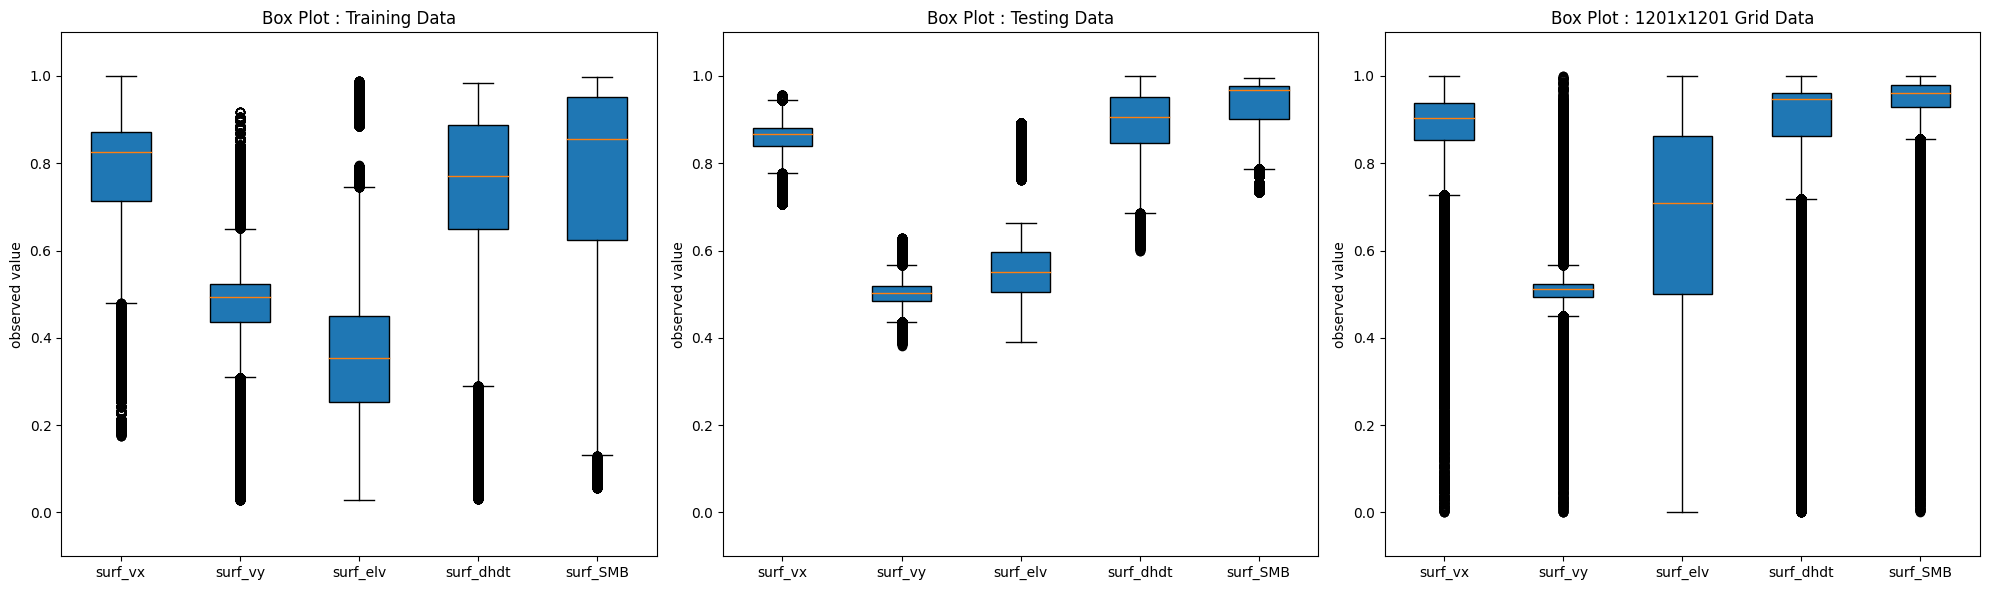

In [20]:
#pd.DataFrame.from_records(data_train_X).boxplot(), pd.DataFrame.from_records(data_test_X).boxplot(), pd.DataFrame.from_records(data_1201_X).boxplot()

import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_elv', 'surf_dhdt', 'surf_SMB']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-0.1, 1.1])
plt.boxplot(data_train_X, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-0.1, 1.1])
plt.boxplot(data_test_X, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : Testing Data') 


plt.subplot(1, 3, 3)
plt.ylim([-0.1, 1.1])
plt.boxplot(data_1201_X, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data') 


plt.tight_layout()
plt.show()

### Training model using old data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_train_X, data_train_Y, test_size=0.30, random_state=100)

In [22]:
xgmodel = XGBRegressor(
    max_depth=4,
    n_estimators=64,
    min_child_weight=0.5, 
    colsample_bytree=0.5, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

# fit model
#model.fit(x1_train, y1_train)
xgmodel.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=True, 
    early_stopping_rounds = 20
    )

#y_pred_test = xgmodel.predict(X_test_given)
#print('RMSE:',np.sqrt(mean_squared_error(Y_test_given,y_pred_test)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.12254	validation_1-rmse:0.12236
[1]	validation_0-rmse:0.11355	validation_1-rmse:0.11339
[2]	validation_0-rmse:0.10551	validation_1-rmse:0.10536
[3]	validation_0-rmse:0.09875	validation_1-rmse:0.09860
[4]	validation_0-rmse:0.09269	validation_1-rmse:0.09256
[5]	validation_0-rmse:0.08754	validation_1-rmse:0.08741
[6]	validation_0-rmse:0.08274	validation_1-rmse:0.08261
[7]	validation_0-rmse:0.07834	validation_1-rmse:0.07821
[8]	validation_0-rmse:0.07478	validation_1-rmse:0.07466
[9]	validation_0-rmse:0.07160	validation_1-rmse:0.07149
[10]	validation_0-rmse:0.06890	validation_1-rmse:0.06880
[11]	validation_0-rmse:0.06639	validation_1-rmse:0.06629
[12]	validation_0-rmse:0.06437	validation_1-rmse:0.06427
[13]	validation_0-rmse:0.06282	validation_1-rmse:0.06272
[14]	validation_0-rmse:0.06100	validation_1-rmse:0.06091
[15]	validation_0-rmse:0.05946	validation_1-rmse:0.05937
[16]	validation_0-rmse:0.05815	validation_1-rmse:0.05806
[17]	validation_0-rmse:0.05711	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, n_estimators=64, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

####Prediction of the track bed on training data

In [23]:
y_pred_train = xgmodel.predict(data_train_X)

In [24]:
y_pred_train.shape, data_train_Y.shape

((396734,), (396734, 1))

In [25]:
y_pred_train_r = y_pred_train.reshape(y_pred_train.shape[0], 1)

In [26]:
train_Predict_full_range = scaler_Y.inverse_transform(y_pred_train_r)
data_train_Y_full_range = scaler_Y.inverse_transform(data_train_Y)

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_train_Y_full_range, train_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_train_Y_full_range, train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_train_Y_full_range, train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_train_Y_full_range, train_Predict_full_range))
print('R^2 Score:', r2_score(data_train_Y_full_range, train_Predict_full_range))

RMSE: 102.76659018872449
RMSE Percentage: 12420.733757051406
RMSE Percentage-1: 808.9481658684573
Mean Absolute Error: 75.7497205224762
Mean Absolute Percentage Error: 1.8919309926580745
R^2 Score: 0.7098475539341468


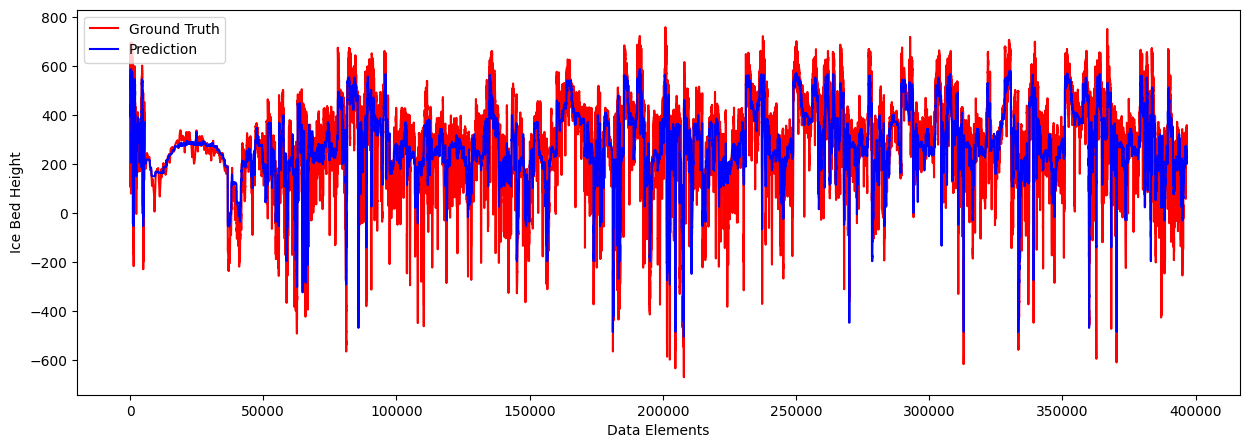

In [28]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(data_train_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(train_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

####Prediction of track bed on test data

In [29]:
y_predict_test = xgmodel.predict(data_test_X)

In [30]:
data_test_Y.shape, y_predict_test.shape

((235972, 1), (235972,))

In [31]:
y_predict_test_r = y_predict_test.reshape(y_predict_test.shape[0], 1)

In [32]:
test_Predict_full_range = scaler_Y.inverse_transform(y_predict_test_r)
data_test_Y_full_range = scaler_Y.inverse_transform(data_test_Y)

In [33]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(data_test_Y_full_range, test_Predict_full_range)))
print('RMSE Percentage:',rmspe(data_test_Y_full_range, test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(data_test_Y_full_range, test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(data_test_Y_full_range, test_Predict_full_range))
print('R^2 Score:', r2_score(data_test_Y_full_range, test_Predict_full_range))

RMSE: 134.79604074322208
RMSE Percentage: 13828.2529715034
RMSE Percentage-1: nan
Mean Absolute Error: 97.1553297508591
Mean Absolute Percentage Error: 1.5780270172067368
R^2 Score: 0.14061275738498658


<ipython-input-4-aa62cd6b9d47>:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100


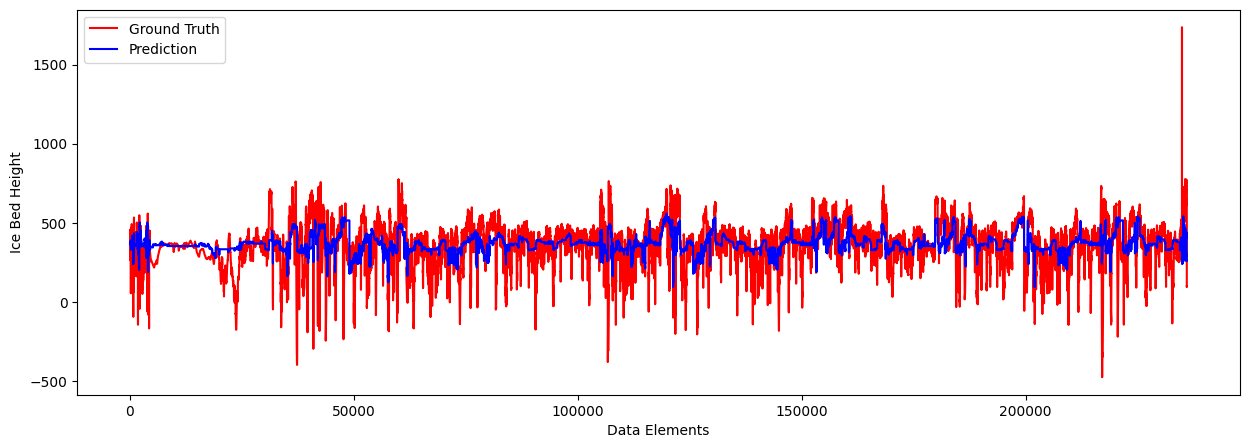

In [34]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(data_test_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(test_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

#### Prediction of ice bed height on 1201x1201 grid data

In [35]:
y_Predict_1201 = xgmodel.predict(data_1201_X)

In [36]:
y_Predict_1201.shape

(1442401,)

In [37]:
y_Predict_1201_r = y_Predict_1201.reshape(y_Predict_1201.shape[0], 1)

In [38]:
y_Predict_1201_full = scaler_Y.inverse_transform(y_Predict_1201_r)

In [39]:
y_Predict_1201_full_flatten=y_Predict_1201_full.flatten()

In [40]:
prediction_on_1201_2D=y_Predict_1201_full_flatten.reshape(1201,1201)
prediction_on_1201_2D.shape

(1201, 1201)

In [ ]:
new_filename_2 = '/content/drive/MyDrive/Ice-bed_dataset/ice_bed_prediction_1201_GB.h5'

with h5py.File(new_filename_2, 'w') as hf:
    hf.create_dataset("track bed prediction",  data=prediction_on_1201_2D)

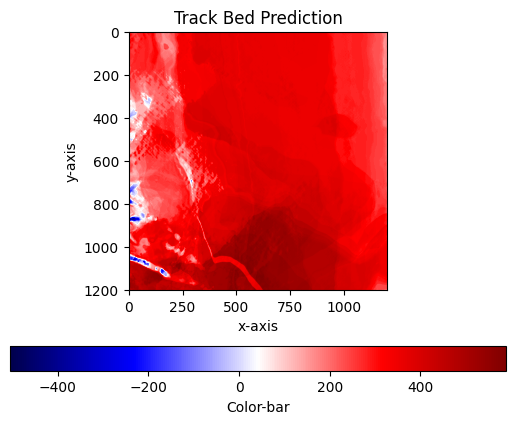

In [41]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(prediction_on_1201_2D), cmap="seismic")
#plt.imshow(a.squeeze(), cmap="seismic", interpolation="nearest") # new interpolated data
plt.title('Track Bed Prediction')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.colorbar(label="Color-bar", orientation="horizontal")

## New Interpolation Data

In [42]:
n_training_data = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/new_interpolated_track_bed_training.csv')
n_testing_data = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/new_interpotaled_track_bed_testing.csv')
n_df_pred = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/y_test.csv')
n_data_1201 = pd.read_csv('/content/drive/MyDrive/Ice-bed_dataset/df_1201.csv')
n_test_data_1201 = n_data_1201.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)

In [43]:
n_training_data

,Unnamed: 0,surf_x,surf_y,track_bed_target,surf_vx,surf_vy,surf_dhdt,surf_SMB,surf_elv
0,0,-206037.406250,-1827384.000,538.235168,-102.379379,2.455286,-0.197761,0.300519,1873.835128
1,1,-205981.171875,-1827518.625,550.491638,-101.973237,2.884405,-0.197749,0.300364,1874.221764
2,2,-205953.109375,-1827586.125,563.800598,-101.784982,2.952367,-0.197750,0.300285,1874.520200
3,3,-205897.078125,-1827720.750,560.530823,-101.493970,2.288839,-0.197765,0.300125,1874.620712
4,4,-205841.328125,-1827855.625,545.708252,-101.271730,1.235018,-0.197797,0.299963,1875.128108
...,...,...,...,...,...,...,...,...,...
396729,396729,-278061.656250,-1720043.625,240.890564,-105.011937,-4.932849,-0.403757,0.144332,1347.292140
396730,396730,-278064.468750,-1720023.125,240.956131,-105.014680,-4.937994,-0.403847,0.144088,1347.204583
396731,396731,-278067.125000,-1720001.375,233.992737,-105.020867,-4.940966,-0.403939,0.143831,1347.069799
396732,396732,-278069.656250,-1719980.875,227.039673,-105.026963,-4.945610,-0.404026,0.143588,1346.941386


In [44]:
n_testing_data

,Unnamed: 0,surf_x,surf_y,surf_vx,surf_vy,surf_dhdt,surf_SMB,surf_elv
0,0,-220038.295520,-1.697568e+06,-81.469318,1.026504,-0.003840,0.374337,1862.341442
1,1,-220038.408158,-1.697642e+06,-81.479483,1.088446,-0.003898,0.374307,1862.340283
2,2,-220038.646540,-1.697789e+06,-81.490122,1.216577,-0.004015,0.374246,1862.337831
3,3,-220038.939782,-1.697936e+06,-81.488490,1.350560,-0.004132,0.374184,1862.310339
4,4,-220039.334272,-1.698083e+06,-81.506943,1.358371,-0.004249,0.374122,1862.314235
...,...,...,...,...,...,...,...,...
235967,235967,-241867.395118,-1.871682e+06,-109.036689,30.657134,-0.411423,-0.017839,1556.905320
235968,235968,-241879.313090,-1.871664e+06,-109.227077,30.716942,-0.411860,-0.017826,1556.788316
235969,235969,-241890.904137,-1.871645e+06,-109.397180,30.763926,-0.412292,-0.017803,1556.660822
235970,235970,-242055.253924,-1.871391e+06,-111.142185,31.286631,-0.418384,-0.016967,1555.680990


In [45]:
n_training_data = n_training_data.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)
n_testing_data = n_testing_data.drop(['Unnamed: 0','surf_x', 'surf_y'],axis=1)

In [46]:
n_training_data.shape, n_testing_data.shape, n_test_data_1201.shape

((396734, 6), (235972, 5), (1442401, 5))

In [47]:
n_training_data.keys(), n_testing_data.keys(), n_test_data_1201.keys()

(Index(['track_bed_target', 'surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB',
        'surf_elv'],
       dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv'], dtype='object'),
 Index(['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv'], dtype='object'))

In [48]:
n_x1_train = n_training_data.iloc[:,1:]
n_y1_train = n_training_data.iloc[:,0:1]
n_X_test_given = n_testing_data.iloc[:,:]
n_Y_test_given = n_df_pred.iloc[:,:]

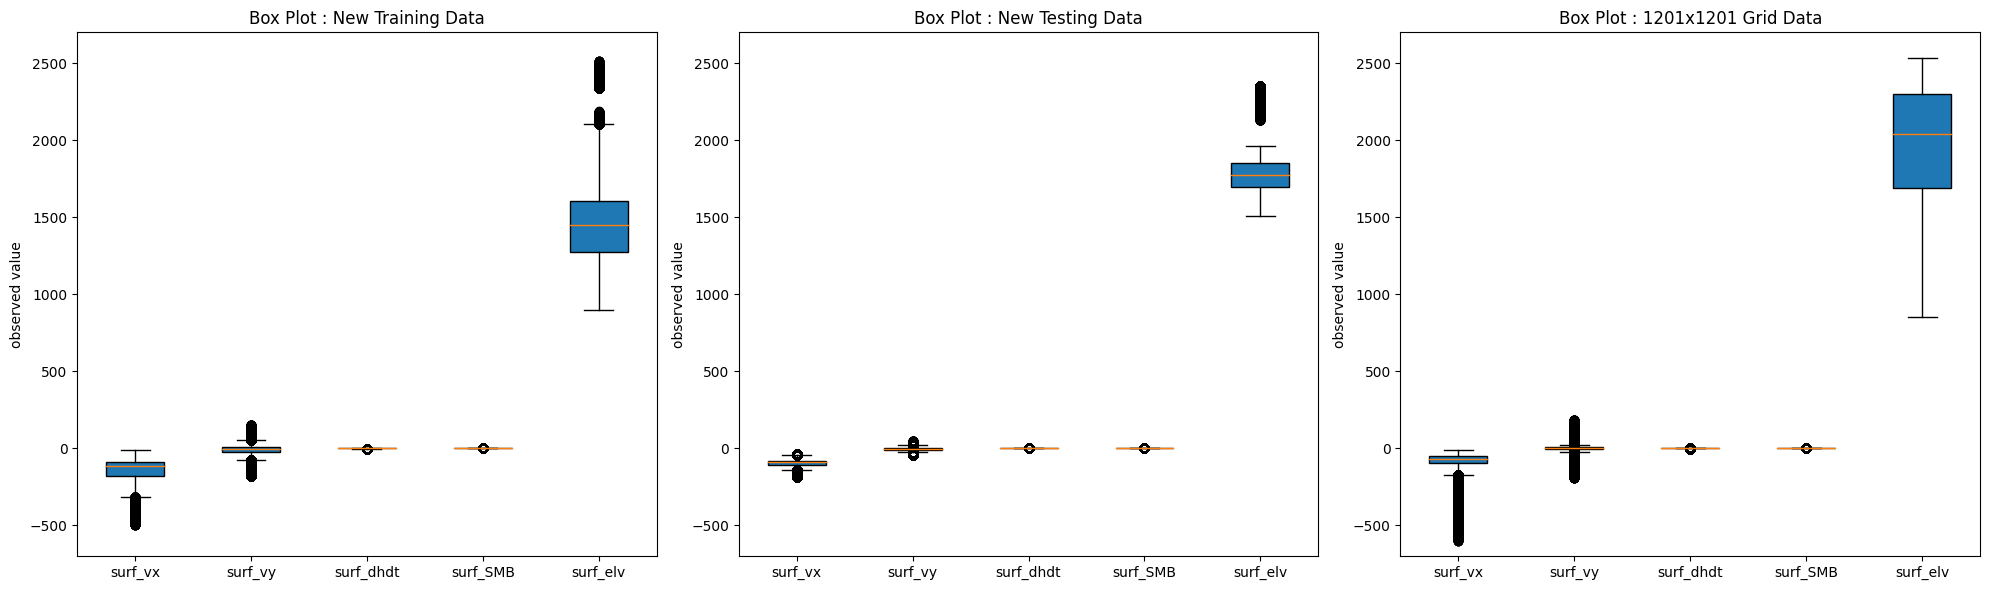

In [49]:
#n_x1_train.boxplot(), n_X_test_given.boxplot(), n_test_data_1201.boxplot()

import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-700, 2700])
plt.boxplot(n_x1_train, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : New Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-700, 2700])
plt.boxplot(n_X_test_given, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : New Testing Data') 


plt.subplot(1, 3, 3)
plt.ylim([-700, 2700])
plt.boxplot(n_test_data_1201, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data') 

plt.tight_layout()
plt.show()

In [50]:
n_x1_train.shape, n_X_test_given.shape, n_test_data_1201.shape

((396734, 5), (235972, 5), (1442401, 5))

In [51]:
n_all_X = np.concatenate((n_x1_train, n_X_test_given, n_test_data_1201), axis=0)
n_all_X.shape

(2075107, 5)

In [52]:
n_y1_train.shape, n_Y_test_given.shape

((396734, 1), (235972, 1))

In [53]:
n_all_Y = np.concatenate((n_y1_train, n_Y_test_given), axis=0)
n_all_Y.shape

(632706, 1)

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

n_all_X_nor = scaler_X.fit_transform(n_all_X)
n_all_Y_nor = scaler_Y.fit_transform(n_all_Y)

In [55]:
n_all_X_nor.shape, n_all_Y_nor.shape

((2075107, 5), (632706, 1))

In [56]:
#seperate the dependent and independent variable for train, test, and 1201 dataset
n_data_train_X = n_all_X_nor[0:396734, :]
n_data_train_Y = n_all_Y_nor[0:396734, :]
n_data_test_X = n_all_X_nor[396734:632706, :]
n_data_test_Y = n_all_Y_nor[396734:, :]
n_data_1201_X = n_all_X_nor[632706:, :]

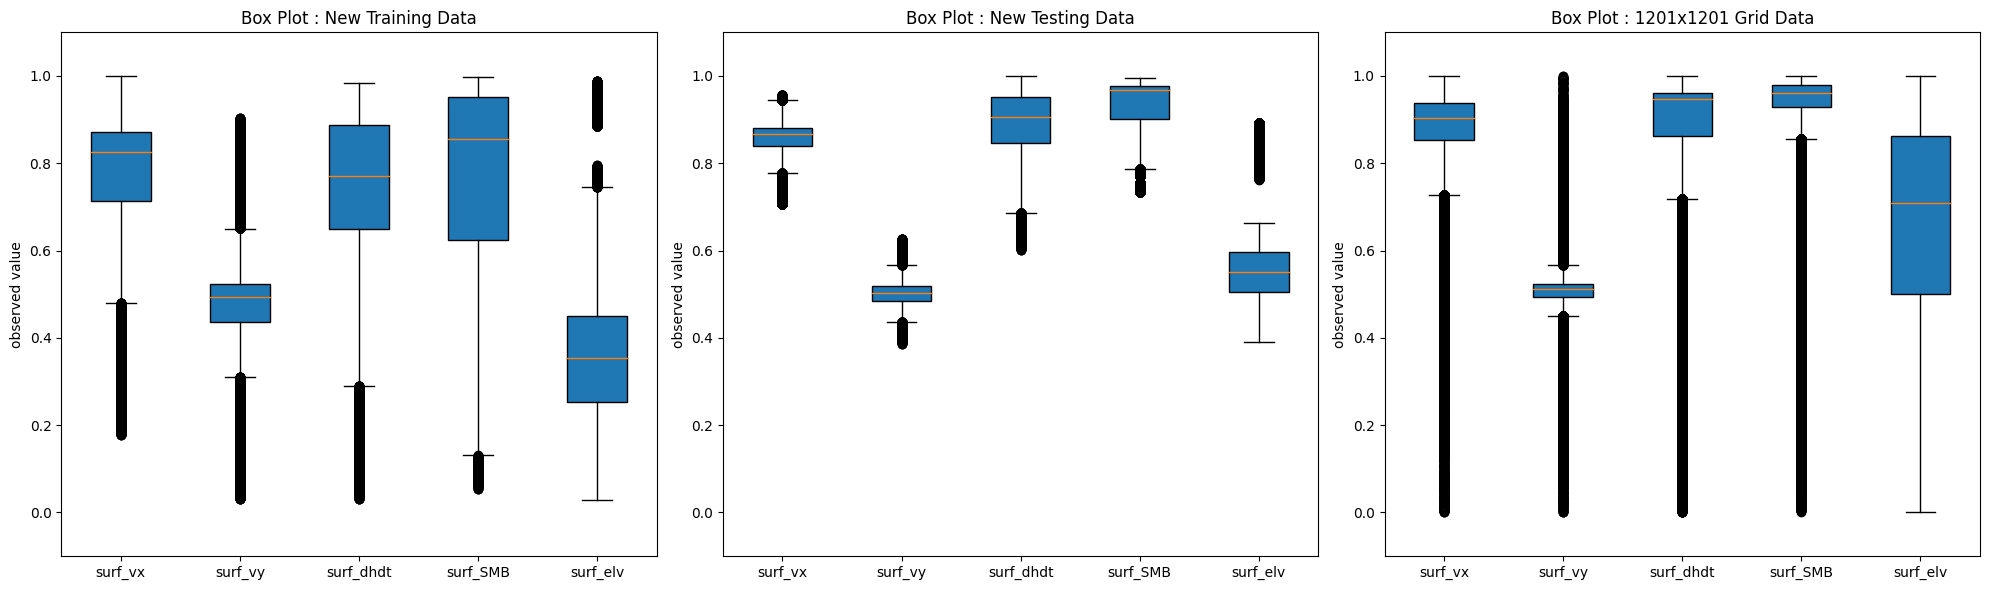

In [57]:
#pd.DataFrame.from_records(n_data_train_X).boxplot(), pd.DataFrame.from_records(n_data_test_X).boxplot(), pd.DataFrame.from_records(n_data_1201_X).boxplot()

import numpy as np
import matplotlib.pyplot as plt

labels = ['surf_vx', 'surf_vy', 'surf_dhdt', 'surf_SMB', 'surf_elv']

#MultipleBoxplot
plt.figure(figsize=(20,6))

plt.subplot(1, 3, 1)
plt.ylim([-0.1, 1.1])
plt.boxplot(n_data_train_X, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : New Training Data')


plt.subplot(1, 3, 2)
plt.ylim([-0.1, 1.1])
plt.boxplot(n_data_test_X, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : New Testing Data') 


plt.subplot(1, 3, 3)
plt.ylim([-0.1, 1.1])
plt.boxplot(n_data_1201_X, vert=True, patch_artist=True, labels=labels) 
plt.ylabel('observed value')
plt.title('Box Plot : 1201x1201 Grid Data') 


plt.tight_layout()
plt.show()



### Training model using new interpolation data

In [58]:
n_X_train, n_X_test, n_y_train, n_y_test = train_test_split(n_data_train_X, n_data_train_Y, test_size=0.30, random_state=100)

In [59]:
n_xgmodel = XGBRegressor(
    max_depth=4,
    n_estimators=64,
    min_child_weight=0.5, 
    colsample_bytree=0.5, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

# fit model
#model.fit(x1_train, y1_train)
n_xgmodel.fit(
    n_X_train, 
    n_y_train, 
    eval_metric="rmse", 
    eval_set=[(n_X_train, n_y_train), (n_X_test, n_y_test)], 
    verbose=True, 
    early_stopping_rounds = 20
    )

#y_pred_test = xgmodel.predict(X_test_given)
#print('RMSE:',np.sqrt(mean_squared_error(Y_test_given,y_pred_test)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.12257	validation_1-rmse:0.12240
[1]	validation_0-rmse:0.11341	validation_1-rmse:0.11325
[2]	validation_0-rmse:0.10564	validation_1-rmse:0.10548
[3]	validation_0-rmse:0.09895	validation_1-rmse:0.09880
[4]	validation_0-rmse:0.09272	validation_1-rmse:0.09258
[5]	validation_0-rmse:0.08726	validation_1-rmse:0.08712
[6]	validation_0-rmse:0.08247	validation_1-rmse:0.08233
[7]	validation_0-rmse:0.07815	validation_1-rmse:0.07802
[8]	validation_0-rmse:0.07439	validation_1-rmse:0.07428
[9]	validation_0-rmse:0.07122	validation_1-rmse:0.07111
[10]	validation_0-rmse:0.06845	validation_1-rmse:0.06835
[11]	validation_0-rmse:0.06605	validation_1-rmse:0.06597
[12]	validation_0-rmse:0.06386	validation_1-rmse:0.06378
[13]	validation_0-rmse:0.06208	validation_1-rmse:0.06200
[14]	validation_0-rmse:0.06036	validation_1-rmse:0.06029
[15]	validation_0-rmse:0.05902	validation_1-rmse:0.05894
[16]	validation_0-rmse:0.05788	validation_1-rmse:0.05781
[17]	validation_0-rmse:0.05674	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=0.5, missing=nan,
             monotone_constraints=None, n_estimators=64, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

####Prediction of the track bed on new training data

In [60]:
n_y_pred_train = n_xgmodel.predict(n_data_train_X)

In [61]:
n_y_pred_train.shape, n_data_train_Y.shape

((396734,), (396734, 1))

In [62]:
n_y_pred_train_r = n_y_pred_train.reshape(n_y_pred_train.shape[0], 1)

In [63]:
n_train_Predict_full_range = scaler_Y.inverse_transform(n_y_pred_train_r)
n_data_train_Y_full_range = scaler_Y.inverse_transform(n_data_train_Y)

In [64]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(n_data_train_Y_full_range, n_train_Predict_full_range)))
print('RMSE Percentage:',rmspe(n_data_train_Y_full_range, n_train_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(n_data_train_Y_full_range, n_train_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(n_data_train_Y_full_range, n_train_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(n_data_train_Y_full_range, n_train_Predict_full_range))
print('R^2 Score:', r2_score(n_data_train_Y_full_range, n_train_Predict_full_range))

RMSE: 101.32670842183745
RMSE Percentage: 12688.401491933959
RMSE Percentage-1: 894.3959682570295
Mean Absolute Error: 74.5049013820991
Mean Absolute Percentage Error: 1.9106712699909203
R^2 Score: 0.7179213526822308


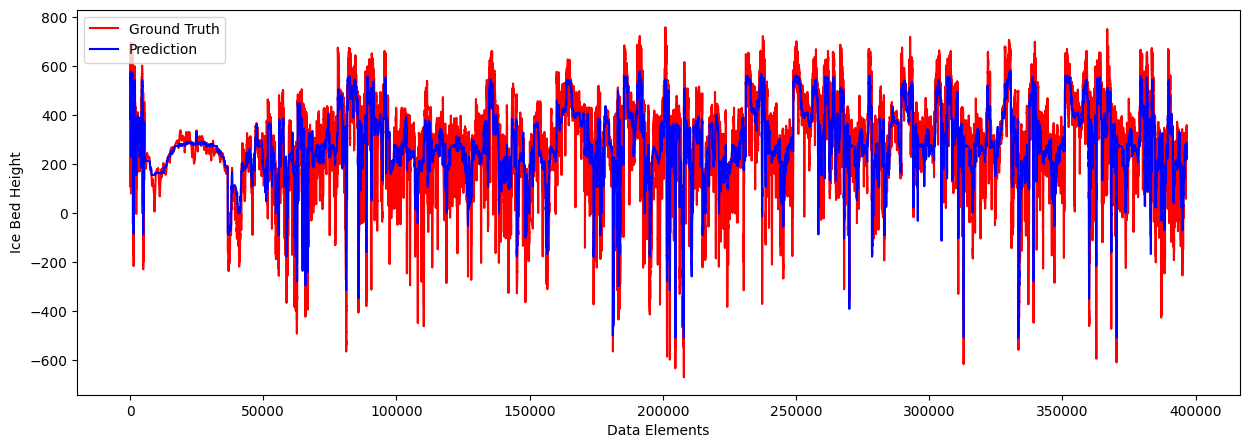

In [65]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(n_data_train_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(n_train_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

####Prediction of track bed on new test data

In [66]:
n_y_predict_test = n_xgmodel.predict(n_data_test_X)

In [67]:
n_data_test_Y.shape, n_y_predict_test.shape

((235972, 1), (235972,))

In [68]:
n_y_predict_test_r = n_y_predict_test.reshape(n_y_predict_test.shape[0], 1)

In [69]:
n_test_Predict_full_range = scaler_Y.inverse_transform(n_y_predict_test_r)
n_data_test_Y_full_range = scaler_Y.inverse_transform(n_data_test_Y)

In [70]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

print('RMSE:',np.sqrt(mean_squared_error(n_data_test_Y_full_range, n_test_Predict_full_range)))
print('RMSE Percentage:',rmspe(n_data_test_Y_full_range, n_test_Predict_full_range))
print('RMSE Percentage-1:',rmspe_1(n_data_test_Y_full_range, n_test_Predict_full_range))
print('Mean Absolute Error:', mean_absolute_error(n_data_test_Y_full_range, n_test_Predict_full_range))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(n_data_test_Y_full_range, n_test_Predict_full_range))
print('R^2 Score:', r2_score(n_data_test_Y_full_range, n_test_Predict_full_range))

RMSE: 143.08734919601025
RMSE Percentage: 14572.896266924019
RMSE Percentage-1: nan
Mean Absolute Error: 105.2251605901228
Mean Absolute Percentage Error: 1.5981560336901908
R^2 Score: 0.03163941030730266


<ipython-input-4-aa62cd6b9d47>:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.nanmean(np.square(y_true - y_pred) / y_true))*100


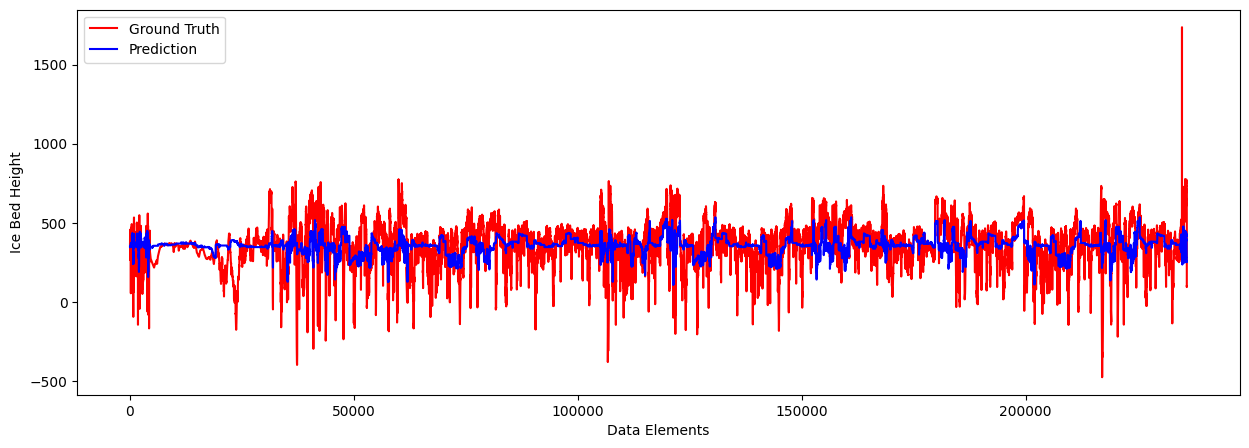

In [71]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(15, 5))

plt.plot(n_data_test_Y_full_range, color='red', label="Ground Truth") # Y_test_given,y_pred_test
plt.plot(n_test_Predict_full_range, color='blue', label="Prediction")
plt.ylabel("Ice Bed Height")
plt.xlabel("Data Elements")
plt.legend(loc="upper left")
plt.show()

#### Prediction of ice bed height on 1201x1201 grid data

In [72]:
n_y_Predict_1201 = n_xgmodel.predict(n_data_1201_X)

In [73]:
n_y_Predict_1201.shape

(1442401,)

In [74]:
n_y_Predict_1201_r = n_y_Predict_1201.reshape(n_y_Predict_1201.shape[0], 1)

In [75]:
n_y_Predict_1201_full = scaler_Y.inverse_transform(n_y_Predict_1201_r)

In [76]:
n_y_Predict_1201_full_flatten=n_y_Predict_1201_full.flatten()

In [77]:
n_prediction_on_1201_2D=n_y_Predict_1201_full_flatten.reshape(1201,1201)
n_prediction_on_1201_2D.shape

(1201, 1201)

In [ ]:
new_filename_2 = '/content/drive/MyDrive/Ice-bed_dataset/ice_bed_prediction_1201_GB_new.h5'

with h5py.File(new_filename_2, 'w') as hf:
    hf.create_dataset("track bed prediction",  data=n_prediction_on_1201_2D)

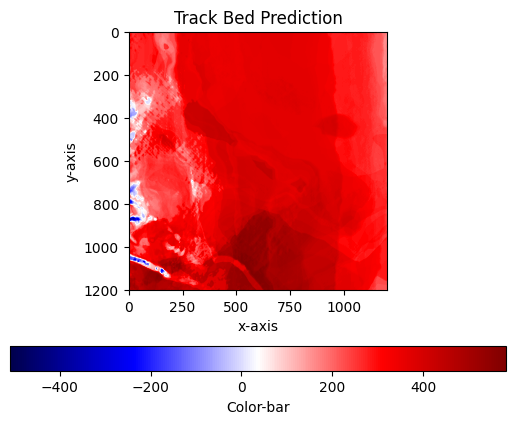

In [78]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(n_prediction_on_1201_2D), cmap="seismic")
#plt.imshow(a.squeeze(), cmap="seismic", interpolation="nearest") # new interpolated data
plt.title('Track Bed Prediction')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.colorbar(label="Color-bar", orientation="horizontal")